In [1]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error

warnings.filterwarnings('ignore')
sns.set_style('darkgrid')

# 4 Modeling a moving average process
Suppose we want to predictthe volume of widget sales from the XYZ Widget Company. 


## 4.1 Defining a moving average process
MA(q):
$$ y_t = \mu + \epsilon_t + \theta_1\epsilon_{t-1} + ... + \theta_q\epsilon_{t-q} $$
An important question is to determine the order q of the MA(q) process. 

### 4.1.1 Identifying the order of a moving average process
We will apply a similar process used in chapter 3:
1. Test for stationarity. 
2. If it is not stationary, apply a transformation to make it stationary. 
3. Plot the ACF and look for significant autocorrelation coefficients.
4. Check whether they become non-significant after lag q.

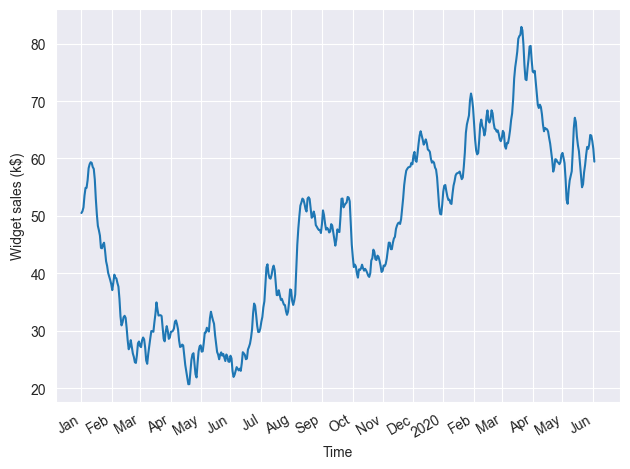

In [2]:
df = pd.read_csv('./data/widget_sales.csv')

fig, ax = plt.subplots()
ax.plot(df['widget_sales'])                                       
ax.set_xlabel('Time')                                             
ax.set_ylabel('Widget sales (k$)')                                
plt.xticks(
    [
        0, 30, 57, 87, 116, 145, 175, 
        204, 234, 264, 293, 323, 352, 
        382, 409, 439, 468, 498
    ], 
    [
        'Jan', 'Feb', 'Mar', 'Apr', 
        'May', 'Jun', 'Jul', 'Aug', 
        'Sep', 'Oct', 'Nov', 'Dec', 
        '2020', 'Feb', 'Mar', 'Apr', 
        'May', 'Jun'
    ]
)
fig.autofmt_xdate()                                               
plt.tight_layout()  

The ADF test implies that the process is not stationary.

In [3]:
ADF_result = adfuller(df['widget_sales'])
print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -1.5121662069359003
p-value: 0.5274845352272627


We can try to stabilize the trend with first-order differencing.

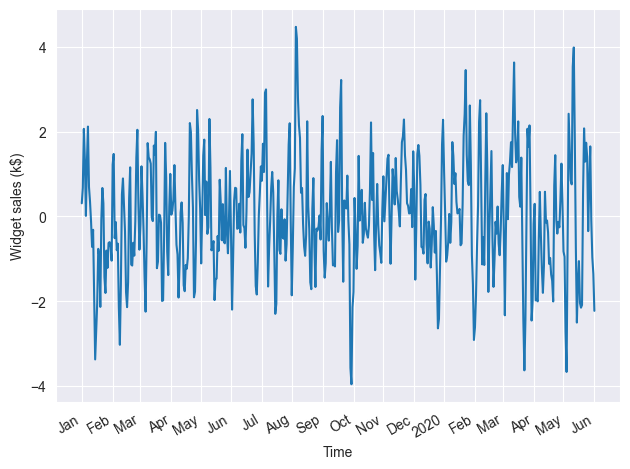

In [4]:
widget_sales_diff = np.diff(df['widget_sales'], n=1)

fig, ax = plt.subplots()
ax.plot(widget_sales_diff)                                       
ax.set_xlabel('Time')                                             
ax.set_ylabel('Widget sales (k$)')                                
plt.xticks(
    [
        0, 30, 57, 87, 116, 145, 175, 
        204, 234, 264, 293, 323, 352, 
        382, 409, 439, 468, 498
    ], 
    [
        'Jan', 'Feb', 'Mar', 'Apr', 
        'May', 'Jun', 'Jul', 'Aug', 
        'Sep', 'Oct', 'Nov', 'Dec', 
        '2020', 'Feb', 'Mar', 'Apr', 
        'May', 'Jun'
    ]
)
fig.autofmt_xdate()                                       
plt.tight_layout()  

Then test for stationarity again.

In [5]:
ADF_result = adfuller(widget_sales_diff)
 
print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -10.576657780341957
p-value: 7.076922818587346e-19


Then plot the autocorrelation function. We can see that there are significant coefficients up until lag 2. Therefore we can use a MA(2) model.

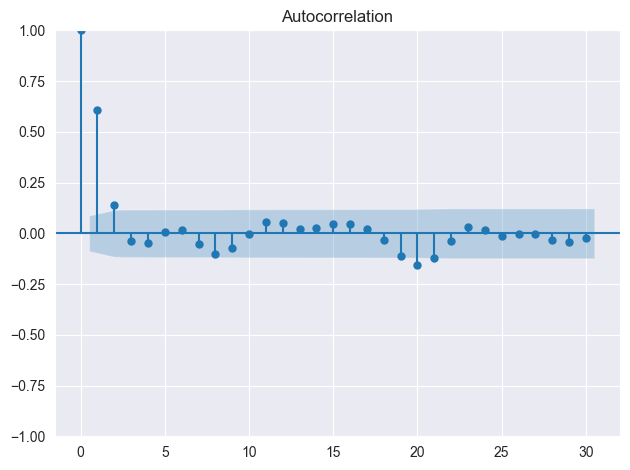

In [6]:
plot_acf(widget_sales_diff, lags=30)
plt.tight_layout()

## 4.2 Forecasting a moving average process

The forecasts must be done on a stationary time series. Therefore we will train and test our model on the differenced volume of widget sales. After forecasting the stationary process, we inverse-transform it.

In [7]:
df_diff = pd.DataFrame({'widget_sales_diff': widget_sales_diff})

train_size = int(0.9 * len(df_diff))
train = df_diff[:train_size]
test = df_diff[train_size:]

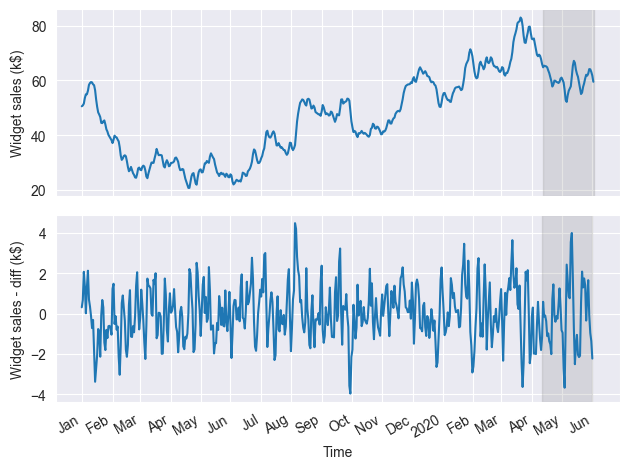

In [8]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True)
 
ax1.plot(df['widget_sales'])
ax1.set_xlabel('Time')
ax1.set_ylabel('Widget sales (k$)')
ax1.axvspan(450, 500, color='#808080', alpha=0.2)

ax2.plot(df_diff['widget_sales_diff'])
ax2.set_xlabel('Time')
ax2.set_ylabel('Widget sales - diff (k$)')
ax2.axvspan(449, 498, color='#808080', alpha=0.2)
 
plt.xticks(
    [0, 30, 57, 87, 116, 145, 175, 204, 234, 264, 293, 323, 352, 382, 409, 439, 468, 498], 
    ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', '2020', 'Feb', 'Mar', 'Apr', 'May', 'Jun']
)

fig.autofmt_xdate()
plt.tight_layout()

For an MA(q) model, we can only forecast at most q steps into the future at one time. We need a *rolling forecast* method. 

In [9]:
def get_rolling_forecast(forecast_next, data: 'array_like', train_size: int, horizon: int, window: int) -> list:
    total_size = train_size + horizon
    predictions = []

    for i in range(train_size, total_size, window):
        out_of_sample_predictions = forecast_next(data[:i], window)
        predictions.extend(out_of_sample_predictions)
    
    return predictions


def forecast_next_by_mean(data, value):
    mean = np.mean(data)
    return [mean for _ in range(window)]


def forecast_next_by_last_value(data, window):
    last_value = data[-1]
    return [last_value for _ in range(window)]


def forecast_next_by_ma(data, window: int) -> list:
    model = SARIMAX(data, order=(0, 0, window))
    res = model.fit(disp=False)
    prediction = res.get_prediction(0, len(data) + window -1)
    return prediction.predicted_mean[-window:]


data = df_diff['widget_sales_diff'].tolist()
train_size = len(train)
horizon = len(test)
window = 2

pred_mean = get_rolling_forecast(forecast_next_by_mean, data, train_size, horizon, window)
pred_last_value = get_rolling_forecast(forecast_next_by_last_value, data, train_size, horizon, window)
pred_ma = get_rolling_forecast(forecast_next_by_ma, data, train_size, horizon, window)

We can visualize the predictions.

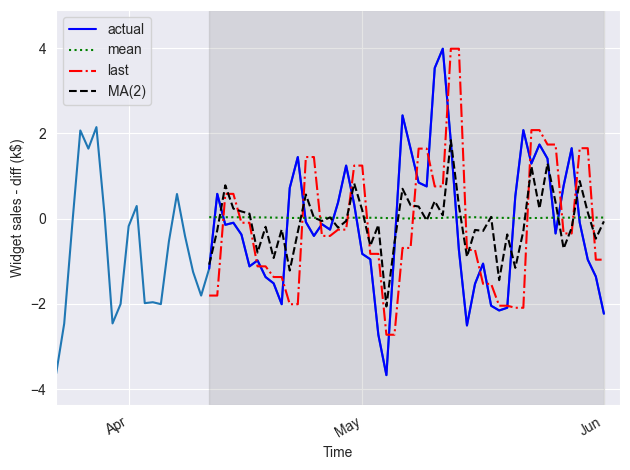

In [10]:
pred_df = test.copy()
pred_df['pred_mean'] = pred_mean
pred_df['pred_last_value'] = pred_last_value
pred_df['pred_MA'] = pred_ma

fig, ax = plt.subplots()

ax.plot(df_diff['widget_sales_diff'])
ax.plot(pred_df['widget_sales_diff'], 'b-', label='actual')
ax.plot(pred_df['pred_mean'], 'g:', label='mean')
ax.plot(pred_df['pred_last_value'], 'r-.', label='last')
ax.plot(pred_df['pred_MA'], 'k--', label='MA(2)')

ax.legend(loc=2)
ax.set_xlabel('Time')
ax.set_ylabel('Widget sales - diff (k$)')
ax.axvspan(449, 498, color='#808080', alpha=0.2)
ax.set_xlim(430, 500)
plt.xticks(
    [439, 468, 498], 
    ['Apr', 'May', 'Jun']
)

fig.autofmt_xdate()
plt.tight_layout()

The mean squared errors imply that the MA(2) process is a better prediction.

In [11]:
mse_mean = mean_squared_error(pred_df['widget_sales_diff'], pred_df['pred_mean'])
mse_last = mean_squared_error(pred_df['widget_sales_diff'], pred_df['pred_last_value'])
mse_ma = mean_squared_error(pred_df['widget_sales_diff'], pred_df['pred_MA'])
 
print(mse_mean, mse_last, mse_ma)

2.5606299456880537 3.2494260812249225 1.9481714497384723


We can cumulatively sum the first order differences to get a prediction on the original time series.

In [12]:
df['pred_widget_sales'] = pd.Series()         
df['pred_widget_sales'][450:] = df['widget_sales'].iloc[450] + pred_df['pred_MA'].cumsum()

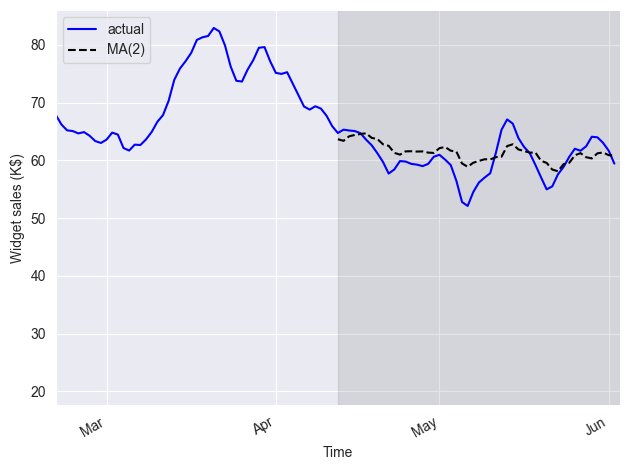

In [13]:
fig, ax = plt.subplots()
 
ax.plot(df['widget_sales'], 'b-', label='actual')        
ax.plot(df['pred_widget_sales'], 'k--', label='MA(2)')   
 
ax.legend(loc=2)
 
ax.set_xlabel('Time')
ax.set_ylabel('Widget sales (K$)')
ax.axvspan(450, 500, color='#808080', alpha=0.2)
ax.set_xlim(400, 500)
 
plt.xticks(
    [409, 439, 468, 498], 
    ['Mar', 'Apr', 'May', 'Jun']
)
 
fig.autofmt_xdate()
plt.tight_layout()

The mean absolute error implies that the prediction is off by $2320 on average. 

In [14]:
mae_MA_undiff = mean_absolute_error(df['widget_sales'].iloc[450:], df['pred_widget_sales'].iloc[450:])
mae_MA_undiff

2.324470924401271